# Data Exploration of Airbnb data for Febrouary,March and April 2019

# Nikoletos Konstantinos - Iglezou Myrto
# sdi1700104 - sdi1700038

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd #this is how I usually import pandas
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number
import folium as fl
import wordcloud as wc
import collections
import seaborn as sbn
import nltk
import itertools
import matplotlib.image as mpimg
from pandas import DataFrame, read_csv
from string import punctuation 
from wordcloud import STOPWORDS,WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import OrderedDict
from operator import itemgetter
from nltk import word_tokenize, BigramCollocationFinder
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer,PorterStemmer
%matplotlib inline
punctuation = list(punctuation)
punctuation.append('’')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\myrto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\myrto\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Read of files and constructing the train.csv

In [3]:
months = ['\\april','\\febrouary','\march']
months2 = ['febrouary','march','april']
files = ['\listings.csv','\listings0.csv']
inputPath= r"C:\Users\myrto\Desktop\data"
# inputPath= r"C:\Users\nikol\Desktop\dataMining_p1\data\data"
columnlist = ['id','zipcode','transit','bedrooms','beds','review_scores_rating','number_of_reviews','neighbourhood','name','latitude','longitude','last_review','instant_bookable','host_since','host_response_rate','host_identity_verified','host_has_profile_pic','first_review','description','city','cancellation_policy','bed_type','bathrooms','accommodates','amenities','room_type','property_type','price','availability_365','minimum_nights','host_id']

framelist = []
monthlist = []
i=0
for month in months:
    for file in files:
        tempfile = pd.read_csv(inputPath+month+file,index_col=False)
        tempframe = pd.DataFrame(data=tempfile)
        framelist.append(tempframe)
    for l in range(0,len(framelist)-1):
        train = framelist[0].combine_first(framelist[l+1])
    df = pd.DataFrame(data = train, columns=columnlist)
    df.drop_duplicates(subset='id',ignore_index=True,inplace=True)  # id is primary key, no duplicates allowed in the same month
    df.insert(loc=len(df.columns),column='month_id',value=months2[i])
    monthlist.append(df)
    i=i+1

df = pd.concat(monthlist)
df['price'] = df['price'].apply(lambda x: x.translate(str.maketrans({',':'','$':''})))
df['price'] = pd.to_numeric(df['price'])

df.replace(to_replace='ΠΑΓΚΡΑΤΙ',value='Pangrati',inplace=True)
df.replace(to_replace='ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ',value='Emporiko Trigono-Plaka',inplace=True)
df.replace(to_replace='ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ',value='Agios Konstantinos-Plateia Vathis',inplace=True)
df.replace(to_replace='ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ',value=' Mouseio-Exarcheia-Neapoli',inplace=True)
df.replace(to_replace='ΠΕΝΤΑΓΩΝΟ',value='Pentagono',inplace=True)

originaldf = df.copy(deep=True)

for x in df.select_dtypes('number').columns:
    df[x].fillna(df[x].mean(),inplace=True)
df.fillna(method='backfill',inplace=True)
df.dropna(inplace=True)
df.to_csv("train.csv")

# Merge of files reviews, reviews0 into a Dataframe 

In [4]:
temp = df[['id','neighbourhood']]
reviews = r'C:\Users\myrto\Desktop\data\april\reviews.csv'
reviews0 = r'C:\Users\myrto\Desktop\data\april\reviews0.csv'
# reviews = r'C:\Users\nikol\Desktop\dataMining_p1\data\data\april\reviews.csv'
# reviews0 = r'C:\Users\nikol\Desktop\dataMining_p1\data\data\april\reviews0.csv'
reviews = pd.read_csv(reviews,usecols=['id','comments'])
reviews0 = pd.read_csv(reviews0)
reviews = pd.DataFrame(data=reviews)
reviews0 = pd.DataFrame(data=reviews0)
reviews = reviews.combine_first(reviews0)
reviews.dropna(inplace=True)

# 1.1 The most common room type

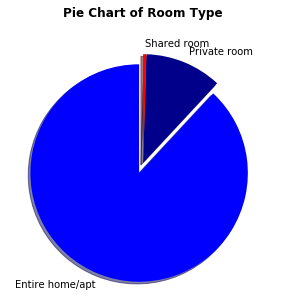

In [5]:
explode = (0.1,0,0)
dt = df['room_type'].value_counts()
dt.plot(kind='pie',figsize=(5,5),title='Most frequent room type',fontsize=10,explode=explode,startangle=90,colors=['blue','darkblue','red'],shadow=True)
plt.title("Pie Chart of Room Type",fontweight='bold',pad=10)
plt.ylabel("")
plt.show()

# 1.2 Average price escalation for the three months

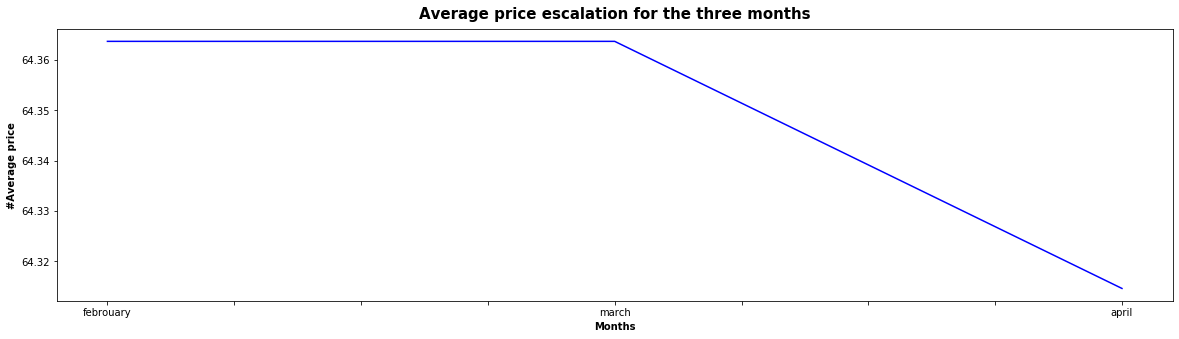

In [6]:
groupbymonth = df.groupby(by='month_id',sort=False)['price'].mean().plot(kind='line',x='per_month',y='price',color='blue',figsize=(20,5),title='Average price scaling for three months')
plt.title('Average price escalation for the three months',fontweight='bold',fontsize=15,pad=10)
plt.ylabel('#Average price',fontweight='bold',fontsize=10)
plt.xlabel('Months',fontweight='bold',fontsize=10)
plt.show()

# 1.3 Five most reviewed neighbourhoods

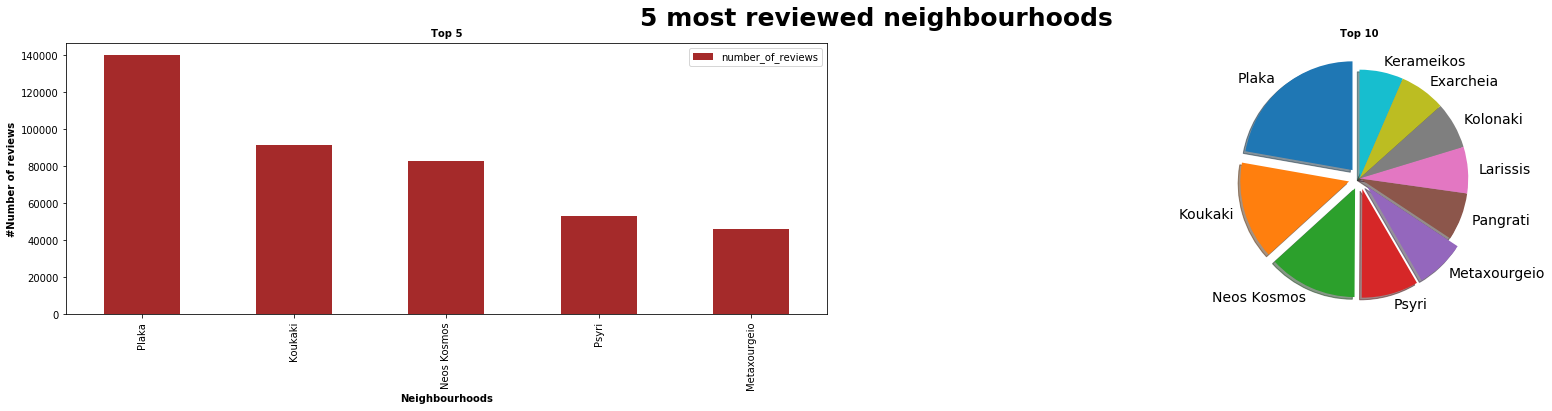

In [7]:
temp = df[['neighbourhood','number_of_reviews']].groupby('neighbourhood',as_index=False).sum()
temp = temp.sort_values(['number_of_reviews'],ascending=False)
explode = (0.1,0.1,0.1,0.1,0.1,0,0,0,0,0)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('5 most reviewed neighbourhoods',fontweight='bold',fontsize=25)
temp.head(5).plot.bar(x='neighbourhood',color='brown',figsize=(20,5),ax=ax1)
ax1.set_title('Top 5',fontweight='bold',fontsize=10)
ax1.set_ylabel('#Number of reviews',fontweight='bold')
ax1.set_xlabel('Neighbourhoods',fontweight='bold')
temp.head(10).plot(kind='pie',x='neighbourhood',y='number_of_reviews',figsize=(30,5),startangle=90, shadow=True, labels=temp['neighbourhood'], legend = False,fontsize=14,explode=explode,ax=ax2)
ax2.set_title('Top 10',fontweight='bold',fontsize=10)
ax2.set_ylabel('')
ax2.set_xlabel('')
fig.subplots_adjust(hspace=0.5)

# 1.4 Neighbourhoods with the most entries

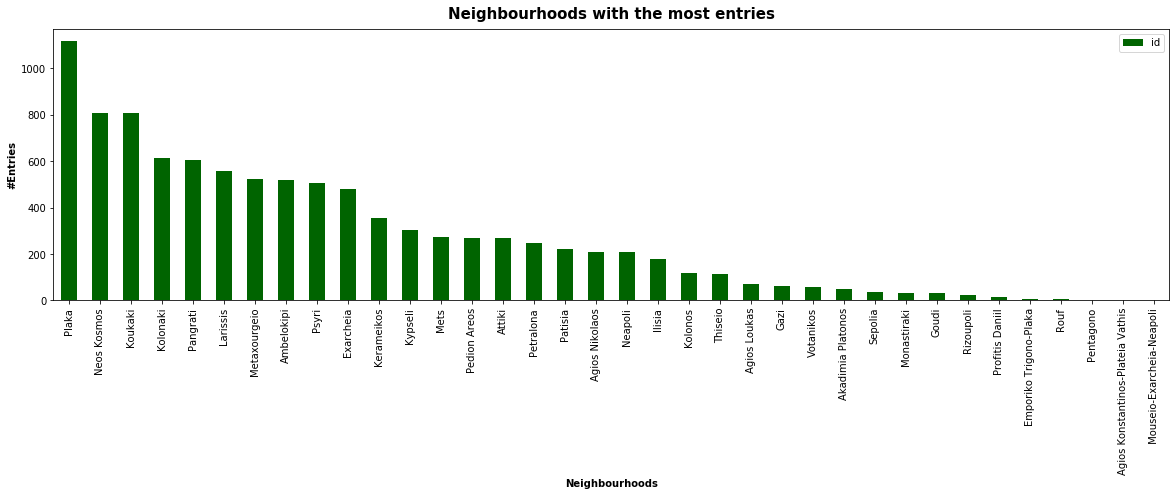

In [8]:
df.groupby(by='neighbourhood',as_index=False).agg({'id':'nunique'}).sort_values(['id'],ascending=False,ignore_index=True).plot.bar(x='neighbourhood',color='darkgreen',figsize=(20,5))
plt.title('Neighbourhoods with the most entries',fontweight='bold',fontsize=15,pad=10)
plt.ylabel('#Entries',fontweight='bold',fontsize=10)
plt.xlabel('Neighbourhoods',fontweight='bold',fontsize=10)
plt.show()

# 1.5 Number of entries per neighbourhood and per month

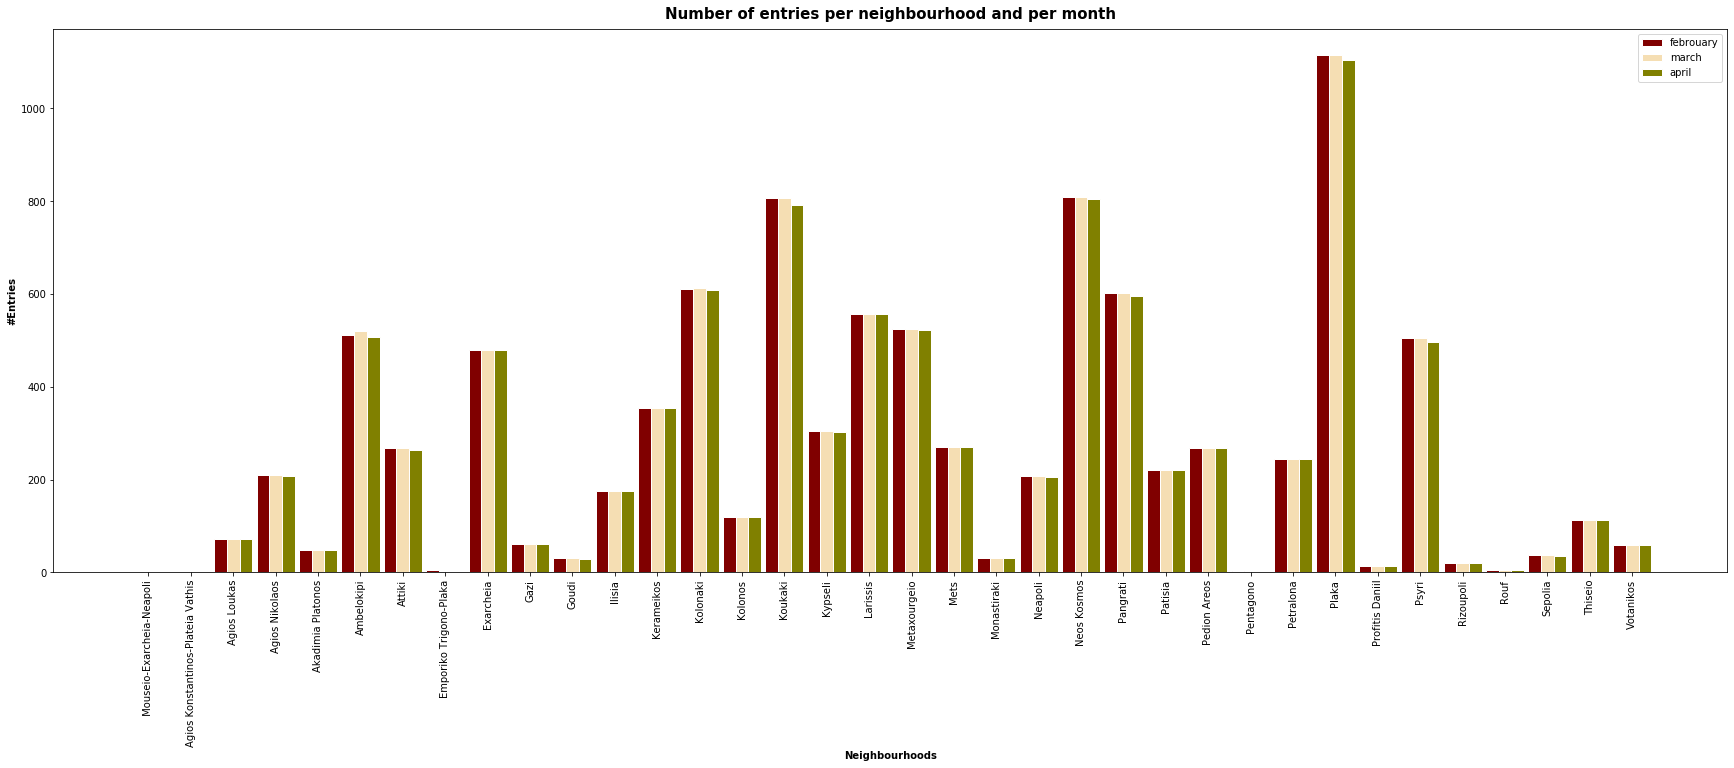

In [9]:
d = {}
templist = []
aprilList = []
marchList = []
febrouaryList = []
groupbyMonth = df
groupbyMonth = groupbyMonth.groupby(['neighbourhood','month_id']).agg({'id':'count'}).reset_index()
groupbyMonth = groupbyMonth.rename(columns = {'id':'Count'})
groupbyMonth.apply(lambda row : templist.append(tuple([row['neighbourhood'],row['month_id'],row['Count']])),axis=1)

for neighbourhood,month,count in templist:
    d[neighbourhood] = {'april':0,'march':0,'febrouary':0}

for neighbourhood,month,count in templist:
    d[neighbourhood][month] = count

neighbourhoodList = [x for x in d.keys()]
for x in neighbourhoodList:
    aprilList.append(d[x]['april'])
    marchList.append(d[x]['march'])
    febrouaryList.append(d[x]['febrouary'])

barWidth = 0.3
plt.figure(figsize=(30,10))
# Set position of bar on X axis
r1 = np.arange(len(neighbourhoodList))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, febrouaryList, color='maroon', width=barWidth, edgecolor='white', label='febrouary')
plt.bar(r2, marchList, color='wheat', width=barWidth, edgecolor='white', label='march')
plt.bar(r3, aprilList, color='olive', width=barWidth, edgecolor='white', label='april')
 
# Add xticks on the middle of the group bars
plt.title('Number of entries per neighbourhood and per month',fontweight='bold',fontsize=15,pad=10)
plt.xlabel('Neighbourhoods', fontweight='bold',fontsize=10)
plt.ylabel('#Entries', fontweight='bold',fontsize=10)
plt.xticks([r + 0.3 for r in range(len(neighbourhoodList))], neighbourhoodList,rotation='vertical')
 
# Create legend & Show graphic
plt.legend()
plt.show()

# 1.6 Neighbourhood column histogram

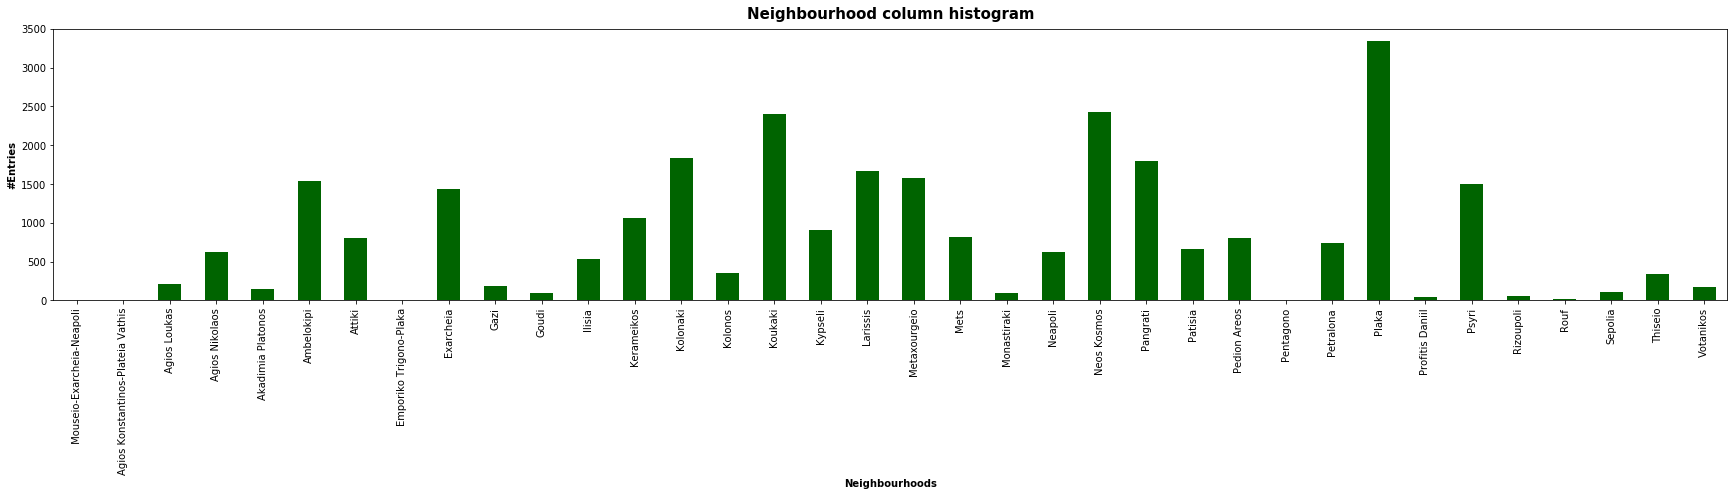

In [10]:
graph = df.groupby(by='neighbourhood').size()
graph.plot.bar(y='Count',color='darkgreen',figsize=(30,5))
plt.title('Neighbourhood column histogram',fontweight='bold',fontsize=15,pad=10)
plt.ylabel('#Entries',fontweight='bold',fontsize=10)
plt.xlabel('Neighbourhoods',fontweight='bold',fontsize=10)
plt.show()

# 1.7 Most frequent room type per neighbourhood

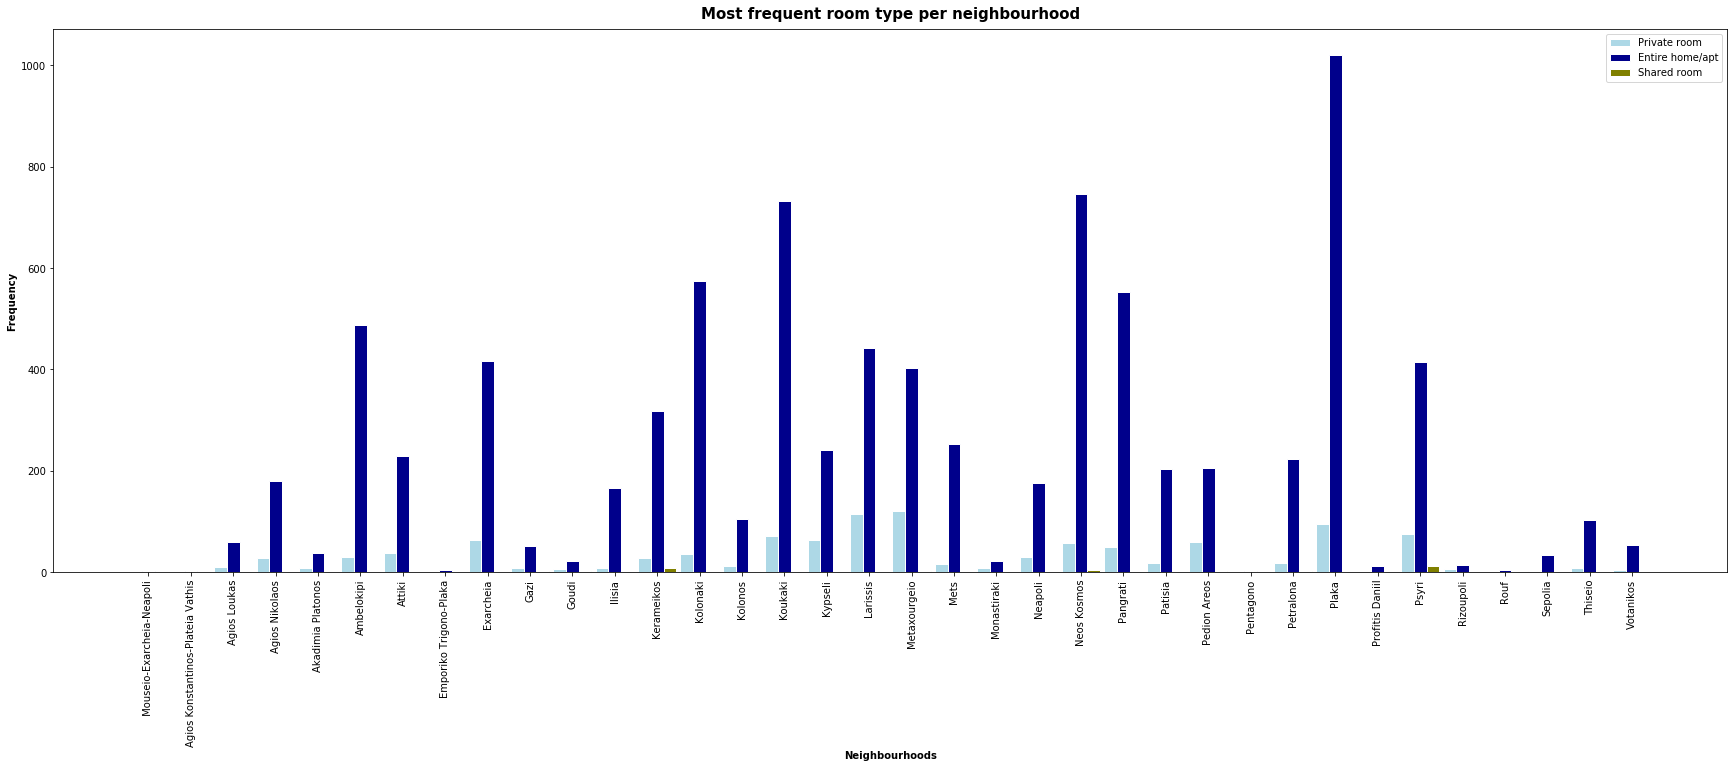

In [11]:
d = {}
templist = []
aptList = []
privateRoomList = []
entireHomeAptList = []
tempDf = df[['room_type','neighbourhood','id']]
tempDf = tempDf.groupby(['neighbourhood','room_type']).agg({'id':'nunique'}).reset_index()
tempDf = tempDf.rename(columns = {'id':'Count'})
tempDf.apply(lambda row : templist.append(tuple([row['neighbourhood'],row['room_type'],row['Count']])),axis=1)

for neighbourhood,type,count in templist:
    d[neighbourhood] = {'Private room':0,'Entire home/apt':0,'Shared room':0}

for neighbourhood,type,count in templist:
    d[neighbourhood][type] = count

neighbourhoodList = [x for x in d.keys()]
for x in neighbourhoodList:
    privateRoomList.append(d[x]['Private room'])
    entireHomeAptList.append(d[x]['Entire home/apt'])
    aptList.append(d[x]['Shared room'])

barWidth = 0.3
plt.figure(figsize=(30,10))
# Set position of bar on X axis
r1 = np.arange(len(neighbourhoodList))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, privateRoomList, color='lightblue', width=barWidth, edgecolor='white', label='Private room')
plt.bar(r2, entireHomeAptList, color='darkblue', width=barWidth, edgecolor='white', label='Entire home/apt')
plt.bar(r3, aptList, color='olive', width=barWidth, edgecolor='white', label='Shared room')
 
# Add xticks on the middle of the group bars
plt.title('Most frequent room type per neighbourhood',fontweight='bold',fontsize=15,pad=10)
plt.xlabel('Neighbourhoods', fontweight='bold',fontsize=10)
plt.ylabel('Frequency', fontweight='bold',fontsize=10)
plt.xticks([r + 0.3 for r in range(len(neighbourhoodList))], neighbourhoodList,rotation='vertical')
 
# Create legend & Show graphic
plt.legend()
plt.show()

# 1.8 Most expensive room type

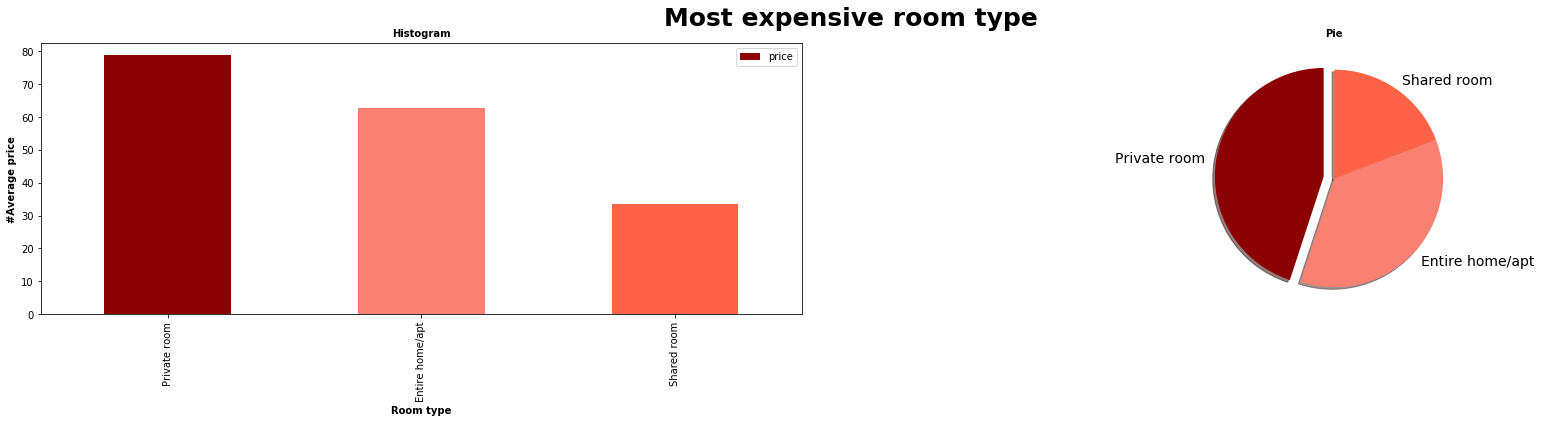

In [12]:
tempdf = df[['room_type','id','price']]
# tempdf.drop_duplicates(subset='id',inplace=True)
temp = tempdf.groupby(by=['room_type'],as_index=False).agg({'price':'mean'}).sort_values(['price'],ascending=False,ignore_index=True)
explode = (0.1,0,0)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Most expensive room type',fontweight='bold',fontsize=25)
temp.plot(kind='bar',x='room_type',y='price',color=['darkred','salmon','tomato'],figsize=(30,5),ax=ax1)
ax1.set_title('Histogram',fontweight='bold',fontsize=10)
ax1.set_ylabel('#Average price',fontweight='bold')
ax1.set_xlabel('Room type',fontweight='bold')
temp.plot(kind='pie',x='room_type',y='price',figsize=(30,5),startangle=90, shadow=True,colors=['darkred','salmon','tomato'], labels=temp['room_type'].unique(), legend = False,fontsize=14,explode=explode,ax=ax2)
ax2.set_title('Pie',fontweight='bold',fontsize=10)
ax2.set_ylabel('')
ax2.set_xlabel('')
fig.subplots_adjust(hspace=0.5)

# 1.9 Folium Map of 100 accommodations in Athens

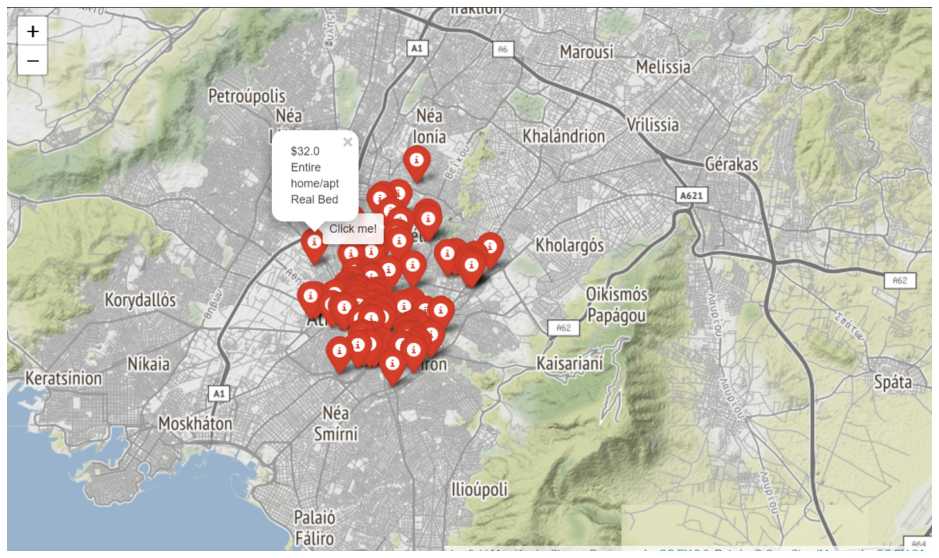

In [13]:
latitude = []
longitude = []
tempdf = DataFrame(data=df[['latitude','longitude','id','price','bed_type','room_type','month_id']])
tempdf = tempdf.loc[tempdf['month_id'] == 'april']

latitude = tempdf['latitude'].tolist()
longitude = tempdf['longitude'].tolist()
price = tempdf['price'].tolist()
btype = tempdf['bed_type'].tolist()
rtype = tempdf['room_type'].tolist()

tooltip = 'Click me!'

m = fl.Map(location=[latitude[0],longitude[0]], zoom_start=12,tiles='Stamen Terrain')

for i, j in zip(range(1,100),range(1,100)):
    fl.Marker(location=[latitude[i], longitude[j]], icon=fl.Icon(color='red', icon='info-sign'),tooltip=tooltip,popup=('$'+str(price[i])+'\n'+str(rtype[i])+'\n'+str(btype[i]))).add_to(m)

img=mpimg.imread('map.png')
plt.figure(figsize=(20,10))
plt.imshow(img,interpolation='bilinear')
plt.axis("off")
plt.show()

# 1.10 Wordcloud of neighbourhoods

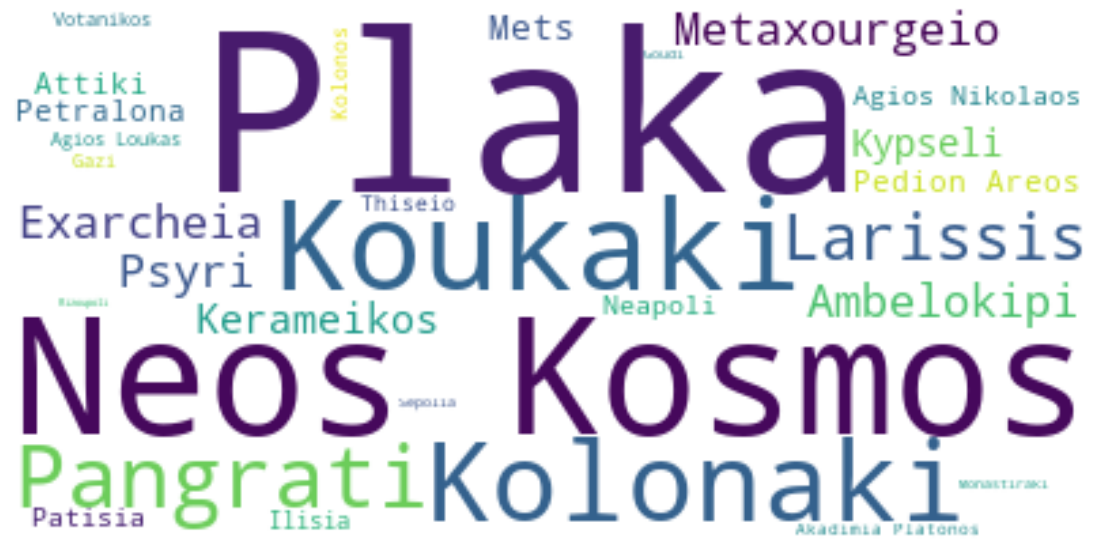

In [14]:
text = df['neighbourhood']
text = text.tolist()
tuples = collections.Counter(text)

words = WordCloud(background_color='white').generate_from_frequencies(frequencies=dict(tuples))

plt.figure(figsize=(20,10))
plt.imshow(words,interpolation='bilinear')
plt.axis("off")
plt.show()

# 1.10 Wordcloud of transit information

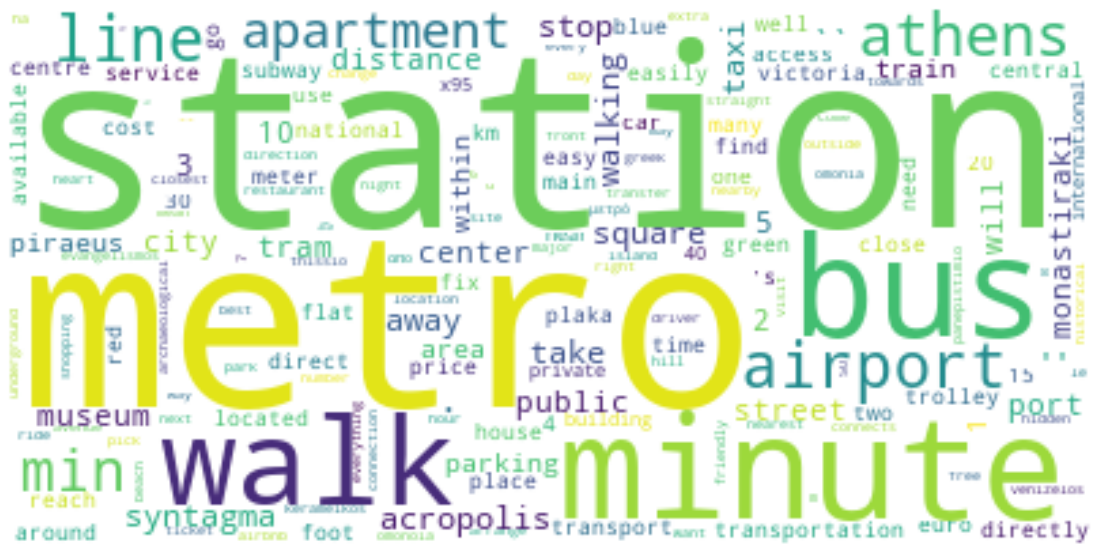

In [15]:
stopwords = set(STOPWORDS)
greek_stopwords = nltk.corpus.stopwords.words('greek')
greek_stopwords = set(greek_stopwords)
stopwords.update(greek_stopwords)

textWords = []
for x in df['transit']:
    for y in word_tokenize(x) :
        y = y.lower()
        y = WordNetLemmatizer().lemmatize(y)
        if (y not in stopwords) and (y not in punctuation):
            textWords.append(y)
            
counter = collections.Counter(textWords)
words = WordCloud(background_color='white',stopwords=stopwords).generate_from_frequencies(frequencies=dict(counter))

plt.figure(figsize=(20,10))
plt.imshow(words,interpolation='bilinear')
plt.axis("off")
plt.show()


# 1.10 Wordcloud of Descriptions

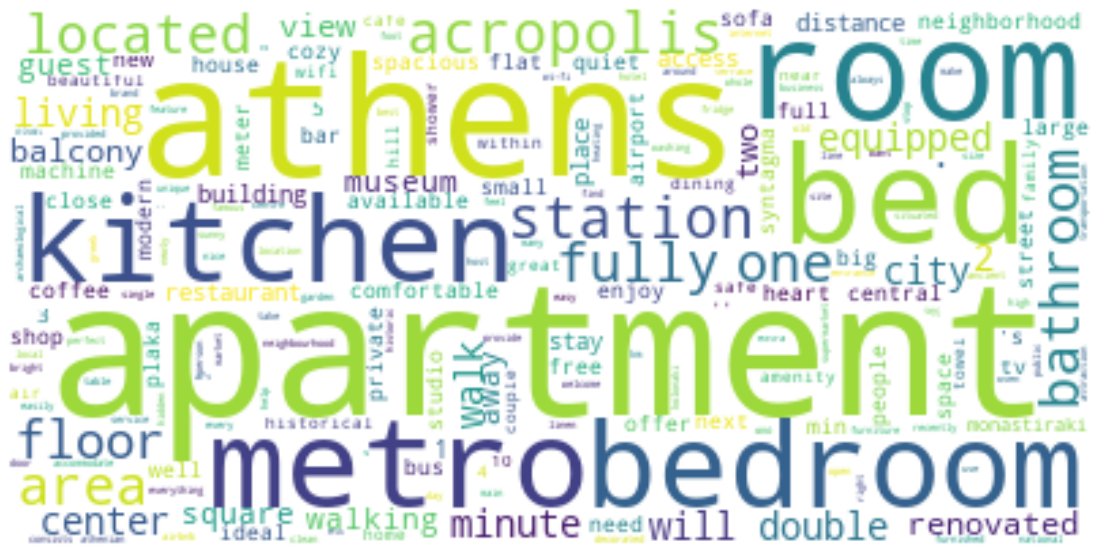

In [17]:
textWords = []
for x in df['description']:
    for y in word_tokenize(x) :
        y = y.lower()
        if (y not in stopwords) and (y not in punctuation):
            y = WordNetLemmatizer().lemmatize(y)
            textWords.append(y)
            
counter = collections.Counter(textWords)
words = WordCloud(background_color='white',stopwords=stopwords).generate_from_frequencies(frequencies=dict(counter))

plt.figure(figsize=(20,10))
plt.imshow(words,interpolation='bilinear')
plt.axis("off")
plt.show()


# 1.10 Wordcloud of last reviews

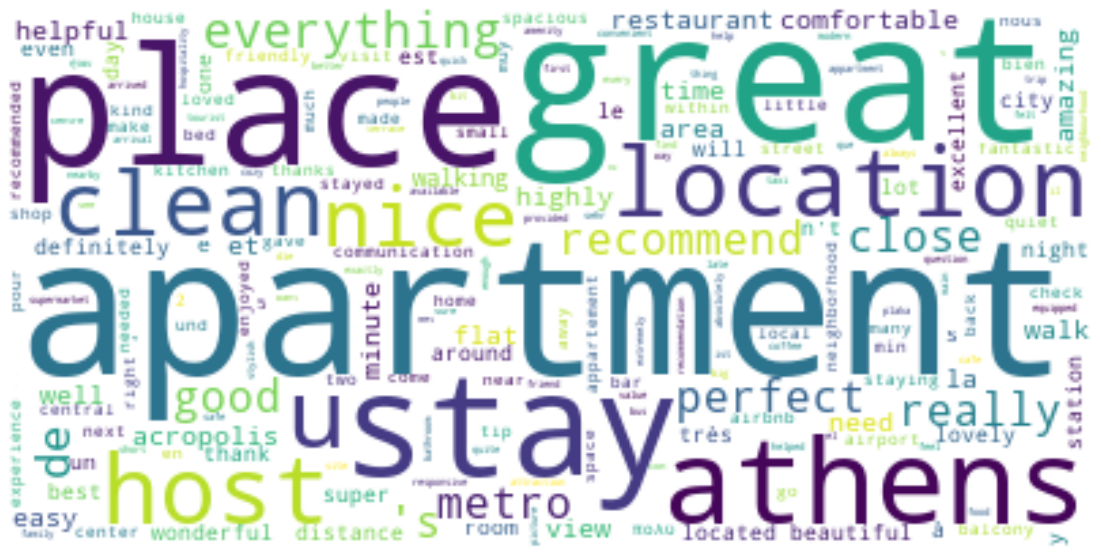

In [18]:
temp = df['last_review']
dates = temp.tolist()
temp = df['id']
ids = temp.tolist()

rev = DataFrame(data=reviews[['date','comments','listing_id']])
temp  = rev.loc[(rev['date'].isin(dates)) & (rev['listing_id'].isin(ids))]

textWords = []
for x in temp['comments']:
    for y in word_tokenize(x) :
        y = y.lower()
        if (y not in stopwords) and (y not in punctuation):
            y = WordNetLemmatizer().lemmatize(y)
            textWords.append(y)
            
counter = collections.Counter(textWords)
words = WordCloud(background_color='white',stopwords=stopwords).generate_from_frequencies(frequencies=dict(counter))

plt.figure(figsize=(20,10))
plt.imshow(words,interpolation='bilinear')
plt.axis("off")
plt.show()

# 12.a Most expensive property type

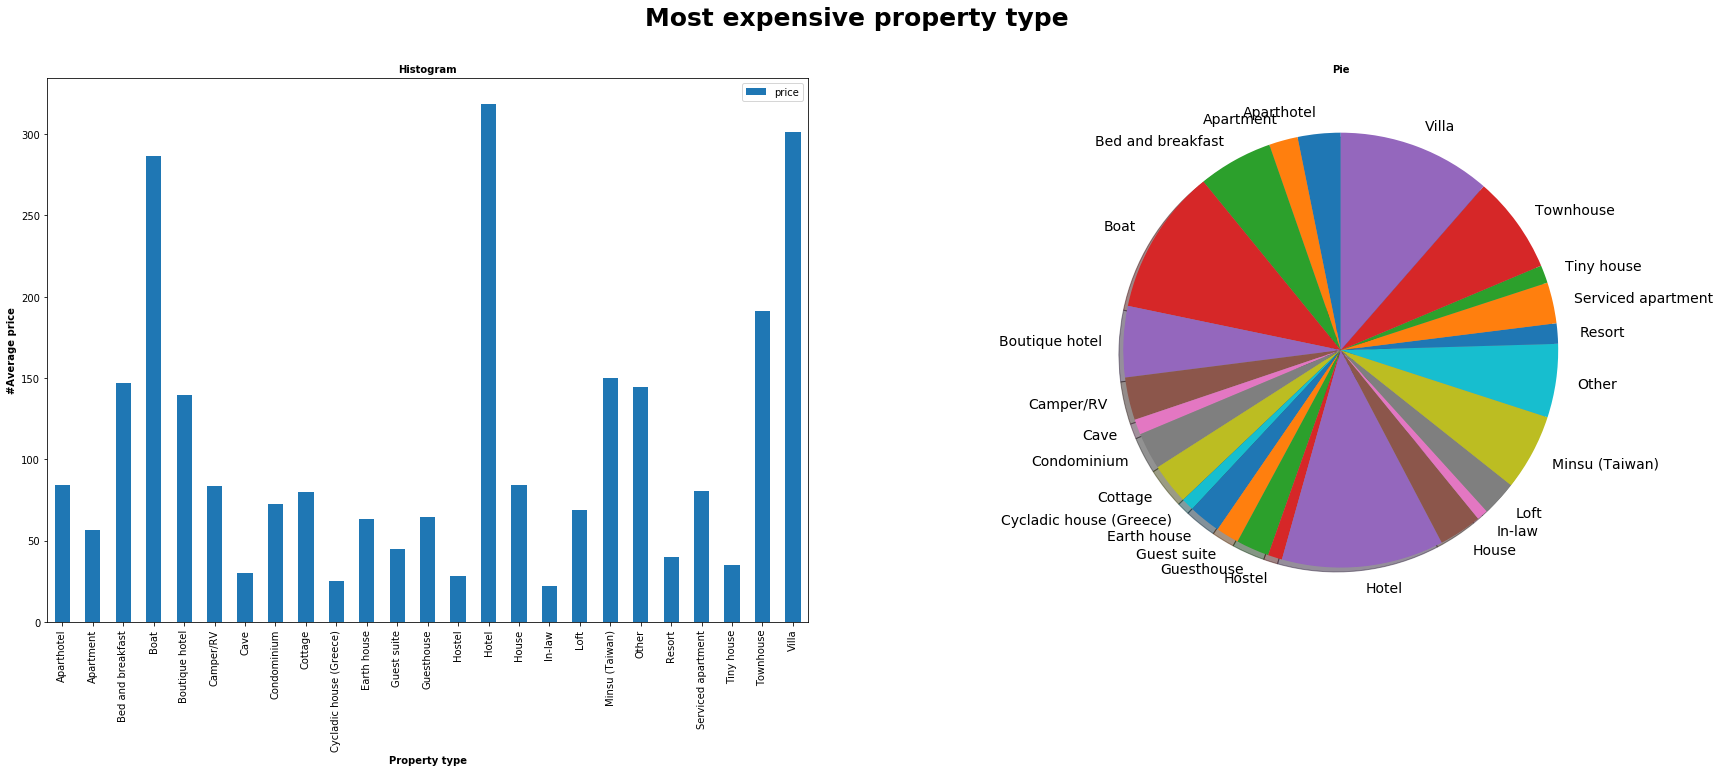

In [19]:
propertyTypeGB = df.groupby('property_type').agg({'price':'mean'}).reset_index()

my_norm = matplotlib.colors.Normalize(vmin=0, vmax=len(propertyTypeGB))
my_cmap = matplotlib.cm.get_cmap('twilight')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Most expensive property type',fontweight='bold',fontsize=25)
propertyTypeGB.plot(kind='bar',x='property_type',y='price',figsize=(30,5),ax=ax1)
ax1.set_title('Histogram',fontweight='bold',fontsize=10)
ax1.set_ylabel('#Average price',fontweight='bold')
ax1.set_xlabel('Property type',fontweight='bold')
propertyTypeGB.plot(kind='pie',x='property_type',y='price',figsize=(30,10),startangle=90, shadow=True, labels=propertyTypeGB['property_type'].unique(),legend = False,fontsize=14,ax=ax2)
ax2.set_title('Pie',fontweight='bold',fontsize=10)
ax2.set_ylabel('')
ax2.set_xlabel('')
fig.subplots_adjust(hspace=0.5)

# 12.b Heat map of average price and average availabilty in Athens for the three months

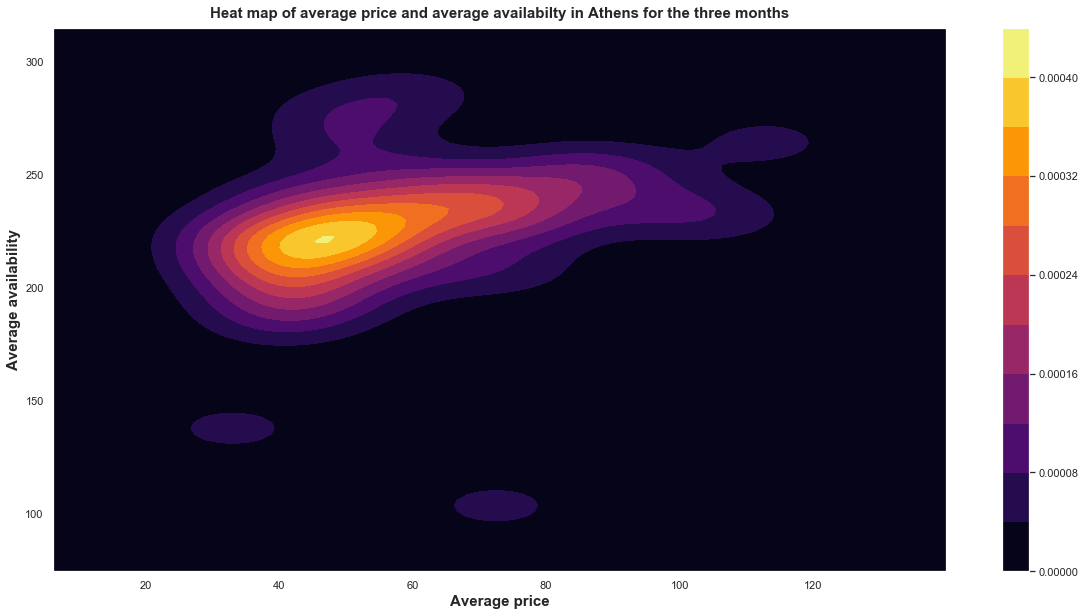

In [22]:
sbn.set()
tempdf = df.drop_duplicates('id')
neighbourhoodsCost = tempdf.groupby('neighbourhood').agg({'price':'mean','availability_365':'mean','id':'count'}).reset_index()
neighbourhoodsCost = neighbourhoodsCost.rename(columns = {'price':'Average price','availability_365':'Average availability','id':'#hotels'})
plt.figure(figsize = (20,10))
plt.title('Heat map of average price and average availabilty in Athens for the three months',fontweight='bold',fontsize=15,pad=10)
plt.xlabel('Average price', fontweight='bold',fontsize=15)
plt.ylabel('Average availability in one year', fontweight='bold',fontsize=15)
sbn.kdeplot(data= neighbourhoodsCost['Average price'],data2=neighbourhoodsCost['Average availability'],cbar=True,cmap="inferno",shade=True,bw='silverman',gridsize=100)

# Recommendation System

In [23]:
df = originaldf.copy(deep=True)
df.fillna('NULL',inplace=True)
table = DataFrame(data=df[['id','name','description']])
table['concat'] = table['name']+ " " +table['description']
table.drop_duplicates(subset='id',inplace=True,ignore_index=True)
stopwords = set(STOPWORDS)
stopwords = [x for x in stopwords]

# 3.1 TF-IDF vector from unigrams and bigrams of name and description concatenation

In [26]:
temp = [x for x in table['concat']]
vectorizer = TfidfVectorizer(max_df=1.0,min_df=1,stop_words=stopwords)
vectors = vectorizer.fit_transform(temp)

C:\Users\myrto\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


# 3.2 100 most similar accommodations in Athens

In [27]:
similarity_matrix = cosine_similarity(vectors)
similarity_matrix = np.triu(similarity_matrix, k=1)

similarity_dictionary = {}
xindex = 0
listid = table['id'].tolist()
for x in similarity_matrix:
    max = x[0]
    maxindex = 0
    yindex = xindex+1
    for yindex in range(xindex+1,len(x)): 
        if x[yindex]>max:
            max=x[yindex]
            maxindex=yindex
        yindex+=1
    idtuple = (listid[xindex],listid[maxindex])
    similarity_dictionary[idtuple] = max 
    xindex+=1

sortedDict = {k : similarity_dictionary[k] for k in sorted(similarity_dictionary,key = similarity_dictionary.get,reverse=True)}
out = dict(itertools.islice(sortedDict.items(), 100))
i=1
print('--------------> 100 most similar accomodations of Athens <------------------\n')
for k,v in out.items():
    print(str(i)+". "+str(k[0])+" with "+str(k[1]) )
    i+=1

--------------> 100 most similar accomodations of Athens <------------------

1. 22074774 with 22074946
2. 22074946 with 22075076
3. 25207595 with 25207888
4. 25941499 with 25941675
5. 25941675 with 26092250
6. 28357206 with 28357761
7. 29122586 with 31879553
8. 29718779 with 33355636
9. 30439676 with 30514173
10. 30514173 with 30514220
11. 32680393 with 32680769
12. 32680769 with 32681311
13. 32681311 with 32704544
14. 32704544 with 32704974
15. 32704974 with 32705240
16. 32825922 with 32851335
17. 32851335 with 32851721
18. 32851721 with 32852415
19. 32881153 with 32881267
20. 32881267 with 32881617
21. 8594460 with 33764094
22. 10603975 with 27162716
23. 18735366 with 20210253
24. 22173279 with 24214247
25. 23552881 with 23554220
26. 23554220 with 23554464
27. 23554464 with 23554584
28. 26125014 with 27282238
29. 26383438 with 26620126
30. 26497308 with 30424563
31. 27282238 with 27686070
32. 27958339 with 27958876
33. 30089884 with 30341020
34. 30097307 with 30917255
35. 30098895 w

# 3.3 Recommendation function

In [28]:
def recommend(item_id,topN,table):

    similarity_dictionary = {}
    stopwords = set(STOPWORDS)
    greek_stopwords = nltk.corpus.stopwords.words('greek')
    greek_stopwords = set(greek_stopwords)
    stopwords.update(greek_stopwords)
    stopwords = [x for x in stopwords]
    rowDocuments = [x for x in table['concat']]
    vectorizer = TfidfVectorizer(max_df=1.0,min_df=1,stop_words=stopwords)
    vectors = vectorizer.fit_transform(rowDocuments)
    similarity_matrix = cosine_similarity(vectors)
    similarity_matrix = np.triu(similarity_matrix, k=1)
    listid = table['id'].tolist()
    wantedIndex =  listid.index(item_id)    

    for index in range(wantedIndex+1,len(similarity_matrix[wantedIndex])): 
        idtuple = (listid[wantedIndex],listid[index])
        similarity_dictionary[idtuple] = similarity_matrix[wantedIndex][index]
        index+=1

    sortedDict = {k : similarity_dictionary[k] for k in sorted(similarity_dictionary,key = similarity_dictionary.get,reverse=True)}
    if topN>len(similarity_matrix[wantedIndex]):
         topN=len(similarity_matrix[wantedIndex])
         print("topN is greater than all other hotels so "+str(topN)+"will be presented")
    out = dict(itertools.islice(sortedDict.items(),topN))
    i=1
    print('Recommending '+ str(topN) +' listings similar to id ' + str(item_id) + ' with name: ' + str(table['name'].values[wantedIndex]))
    print('----------------------------------------------------------------------------------------------------')
    for k,v in out.items():
        print(""+str(i)+'. id: '+str(k[1]))
        similarityindex = listid.index(k[1])
        print('-Recommended: '+str(table['name'].values[similarityindex]))
        print('-Description: '+'\n\t'+str(table['description'].values[similarityindex]))
        print('-> Score : %.5f' % v)
        i+=1
        print("\n")

recommend(33558429,15,table)

C:\Users\myrto\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn', 'δι', 'ἀλλ'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Recommending 15 listings similar to id 33558429 with name: JR SUITE CENTRAL ATHENS GAZI VIEW "PERSEFONI"
----------------------------------------------------------------------------------------------------
1. id: 33636471
-Recommended: Luxury modern apartment , near the center !!
-Description: 
	Το διαμέρισμα είναι πλήρως ανακαινισμένο προσφέροντας μια όμορφη διαμονή . Η δυνατότητα φιλοξενίας είναι από 1 έως 3 άτομα . Βρίσκεται λίγα λεπτά μακριά μακριά από το σταθμό του τρένου κάτω Πατήσια Το διαμέρισμα είναι πλήρως ανακαινισμένο προσφέροντας μια όμορφη διαμονή. Η δυνατότητα φιλοξενίας είναι για ένα έως τρία άτομα . Παρέχεται ένα διπλό κρεβάτι , ένας καναπές-κρεβάτι , μια κουζίνα με όλο τον οικιακό εξοπλισμό και ένα άνετο απολαυστικό μπάνιο Ολοκληρωτικά σε όλο το διαμέρισμα Δεν θα βρίσκομαι στην ίδια ιδιοκτησία αλλα θα είμαι διαθέσιμη για οτιδήποτε κατά τη διάρκεια της διαμονής σας Ο χώρος μου βρίσκεται σε μια ήσυχη γειτονιά κοντά στο κέντρο της Αθήνας . Γύρω από αυτή βρίσκεις οτιδήποτ

# 3.4 10 most common-used word bigrams 

In [29]:
textWords = []
for x in table['concat']:
    for y in word_tokenize(x):
        if y not in punctuation:
            textWords.append(y)

stopwords = set(STOPWORDS)
greek_stopwords = nltk.corpus.stopwords.words('greek')
greek_stopwords = set(greek_stopwords)
stopwords.update(greek_stopwords)
stopwords = [x for x in stopwords]

finder = BigramCollocationFinder.from_words(textWords)
finder.apply_word_filter(lambda w: w.lower() in stopwords)
bigram_measures = nltk.collocations.BigramAssocMeasures()
mostCommon = finder.nbest(bigram_measures.likelihood_ratio,10)

print("-------- 10 most common-used word bigrams ------------")
i=1
for word in mostCommon:
    print(str(i)+". "+str(word[0])+" -> "+str(word[1]))
    i+=1

-------- 10 most common-used word bigrams ------------
1. living -> room
2. fully -> equipped
3. walking -> distance
4. metro -> station
5. double -> bed
6. equipped -> kitchen
7. washing -> machine
8. brand -> new
9. minutes -> walk
10. sofa -> bed
